In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable
print(f"Using device: {device}")

Using device: cuda


In [3]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [5]:
# Define file paths
model_path = r'C:\Users\k54739\Bibi_new_thesis\saved_model\sweetcrop_simclr_model_epoch_245.pth'

In [7]:
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_6344\3778111997.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Inference before projection head

# Logistic

In [8]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [9]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    #classes = ['untreated', 'single_dose', 'drug_screened']
    classes = ['control', 'treated']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\train_sd"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [10]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0])


In [11]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in train_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in train_loader_labeled: {total_images}")


Total number of images in train_loader_labeled: 178


In [12]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in test_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in test_loader_labeled: {total_images}")


Total number of images in test_loader_labeled: 45


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [15]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

  8%|▊         | 1/12 [00:01<00:11,  1.03s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 17%|█▋        | 2/12 [00:01<00:08,  1.18it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 25%|██▌       | 3/12 [00:02<00:07,  1.28it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 33%|███▎      | 4/12 [00:03<00:06,  1.28it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 42%|████▏     | 5/12 [00:03<00:05,  1.30it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 6/12 [00:04<00:04,  1.30it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 58%|█████▊    | 7/12 [00:05<00:03,  1.31it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 67%|██████▋   | 8/12 [00:06<00:02,  1.35it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 9/12 [00:06<00:02,  1.39it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 83%|████████▎ | 10/12 [00:07<00:01,  1.33it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch features shape: torch.Size([2, 512])
Batch labels shape: torch.Size([2])
Features shape after concatenation: torch.Size([178, 512])
Labels shape after concatenation: torch.Size([178])


 33%|███▎      | 1/3 [00:00<00:01,  1.56it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 67%|██████▋   | 2/3 [00:01<00:00,  1.53it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

Batch features shape: torch.Size([13, 512])
Batch labels shape: torch.Size([13])
Features shape after concatenation: torch.Size([45, 512])
Labels shape after concatenation: torch.Size([45])


In [16]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [17]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [18]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [19]:
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                             drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Track best by accuracy
    best_test_acc = -1.0
    best_model_state_acc = None

    # Track best by loss (with accuracy as a tiebreaker)
    best_test_loss = float('inf')
    best_test_loss_acc = -1.0
    best_model_state_loss = None

    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)

        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Check for best accuracy model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state_acc = model.state_dict()

        # Check for best loss model
        # Condition: strictly lower loss OR equal loss but higher accuracy
        if (test_loss < best_test_loss) or (test_loss == best_test_loss and test_acc > best_test_loss_acc):
            best_test_loss = test_loss
            best_test_loss_acc = test_acc
            best_model_state_loss = model.state_dict()

    # Now we have two best states: best_model_state_acc and best_model_state_loss
    # Create two separate model instances for them
    best_acc_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_acc_model.load_state_dict(best_model_state_acc)
    best_acc_model.eval()

    best_loss_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_loss_model.load_state_dict(best_model_state_loss)
    best_loss_model.eval()

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return both models and the final results (e.g., last train_acc and test_acc recorded)
    return best_acc_model, best_loss_model, {"train_acc": train_acc, "test_acc": test_acc}


Epoch 1/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 3449.26it/s]


Training loss: 0.3943, Training accuracy: 0.8315
Test loss: 0.1116, Test accuracy: 0.9778
Epoch 2/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0461, Training accuracy: 1.0000
Test loss: 0.0462, Test accuracy: 0.9778
Epoch 3/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0217, Training accuracy: 1.0000
Test loss: 0.0343, Test accuracy: 0.9778
Epoch 4/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0148, Training accuracy: 1.0000
Test loss: 0.0282, Test accuracy: 1.0000
Epoch 5/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0113, Training accuracy: 1.0000
Test loss: 0.0242, Test accuracy: 1.0000
Epoch 6/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.67it/s]


Training loss: 0.0093, Training accuracy: 1.0000
Test loss: 0.0216, Test accuracy: 1.0000
Epoch 7/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0074, Training accuracy: 1.0000
Test loss: 0.0191, Test accuracy: 1.0000
Epoch 8/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0064, Training accuracy: 1.0000
Test loss: 0.0174, Test accuracy: 1.0000
Epoch 9/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0057, Training accuracy: 1.0000
Test loss: 0.0163, Test accuracy: 1.0000
Epoch 10/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0048, Training accuracy: 1.0000
Test loss: 0.0148, Test accuracy: 1.0000
Epoch 11/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 4491.49it/s]


Training loss: 0.0041, Training accuracy: 1.0000
Test loss: 0.0139, Test accuracy: 1.0000
Epoch 12/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0037, Training accuracy: 1.0000
Test loss: 0.0134, Test accuracy: 1.0000
Epoch 13/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0035, Training accuracy: 1.0000
Test loss: 0.0129, Test accuracy: 1.0000
Epoch 14/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0030, Training accuracy: 1.0000
Test loss: 0.0121, Test accuracy: 1.0000
Epoch 15/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 368.05it/s]


Training loss: 0.0028, Training accuracy: 1.0000
Test loss: 0.0118, Test accuracy: 1.0000
Epoch 16/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0026, Training accuracy: 1.0000
Test loss: 0.0112, Test accuracy: 1.0000
Epoch 17/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0022, Training accuracy: 1.0000
Test loss: 0.0104, Test accuracy: 1.0000
Epoch 18/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0021, Training accuracy: 1.0000
Test loss: 0.0100, Test accuracy: 1.0000
Epoch 19/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0098, Test accuracy: 1.0000
Epoch 20/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.92it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0095, Test accuracy: 1.0000
Epoch 21/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0093, Test accuracy: 1.0000
Epoch 22/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0088, Test accuracy: 1.0000
Epoch 23/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0087, Test accuracy: 1.0000
Epoch 24/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0084, Test accuracy: 1.0000
Epoch 25/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.41it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0079, Test accuracy: 1.0000
Epoch 26/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 27/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 28/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 29/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 816.38it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 30/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 31/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 32/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 368.28it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 33/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 34/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 2040.86it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 35/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 3001.29it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 36/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 1998.87it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 37/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 3000.93it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 38/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 39/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 40/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 41/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.88it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 42/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 43/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 44/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 45/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 322.80it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 46/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 599.97it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 47/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.40it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 48/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 545.52it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 49/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 600.03it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 50/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 368.81it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 51/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.56it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 52/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.09it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 53/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 54/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 447.91it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 55/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 370.39it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 56/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 57/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 368.81it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 58/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.96it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 59/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 409.02it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 60/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 1131.20it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 61/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.11it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 62/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.16it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 63/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 6737.84it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 64/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 65/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 2640.14it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 66/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 67/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 413.95it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 68/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 818.37it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 69/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 70/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 346.22it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 71/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.98it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 72/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 2034.10it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 73/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 381.29it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 74/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 387.20it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 75/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 76/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.63it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 77/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.62it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 78/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.68it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 79/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.53it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 80/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 514.40it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 81/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 82/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 322.01it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 83/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 434.81it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 84/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.97it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 85/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 86/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.17it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 87/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.12it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 88/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.24it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 89/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 261.24it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 90/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 5100.49it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 91/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 92/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.48it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 93/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.50it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 94/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.25it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 95/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 96/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.79it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 97/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 98/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.49it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 99/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.75it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 100/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 454.60it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 101/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 545.51it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 102/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 103/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.77it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 104/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 331.91it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 105/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 106/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 107/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 108/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 109/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 6332.62it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 110/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 111/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 112/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 113/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 114/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 115/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 116/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.31it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 117/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 118/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.64it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 119/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 3173.50it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 120/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 302.55it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 121/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 406.43it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 122/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.72it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 123/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 124/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 230.48it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 125/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 500.07it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 126/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 4897.03it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 127/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 838.08it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 128/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.96it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 129/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 130/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.78it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 131/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.04it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 132/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 133/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 134/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 135/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 136/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.69it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 137/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 138/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 139/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 369.46it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 140/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 369.81it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 141/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.97it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 142/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 143/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 144/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 145/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 146/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 251.36it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 147/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 148/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 2642.36it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 149/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 325.82it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 150/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 277.41it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 151/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.97it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 152/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 153/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 154/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 337.43it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 155/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.91it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 156/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 388.69it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 157/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 158/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.92it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 159/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 6331.02it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 160/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.22it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 161/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 162/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 163/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 537.18it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 164/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 165/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 166/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 288.55it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 167/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 500.03it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 168/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.72it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 169/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.72it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 170/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 171/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 600.01it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 172/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 173/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.02it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 174/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 175/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 500.05it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 176/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.96it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 177/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 178/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 328.72it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 179/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 180/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 332.26it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 181/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 166.48it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 182/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 183/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 184/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 185/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.97it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 186/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 187/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 188/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 189/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.96it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 190/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.91it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 191/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 192/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 193/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.97it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 194/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 195/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 196/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.02it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 197/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 280.05it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 198/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.42it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 199/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 200/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 201/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 400.07it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 202/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 520.22it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 203/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.89it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 204/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 205/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 644.75it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 206/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 207/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 208/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.02it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 209/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 210/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 211/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 212/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 213/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 214/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 215/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 216/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 217/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.02it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 218/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 219/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 220/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 221/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 463.25it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 222/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 194.15it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 223/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 333.48it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 224/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.96it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 225/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 226/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 227/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 228/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 229/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 230/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 512.04it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 231/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 346.07it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 232/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.96it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 233/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.97it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 234/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 235/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 330.78it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 236/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 237/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 238/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 239/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 240/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 241/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.97it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 242/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 243/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0063, Test accuracy: 1.0000
Epoch 244/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 342.53it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0063, Test accuracy: 1.0000
Epoch 245/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0063, Test accuracy: 1.0000
Epoch 246/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.96it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0063, Test accuracy: 1.0000
Epoch 247/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0063, Test accuracy: 1.0000
Epoch 248/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 249/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 250/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 251/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 252/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 253/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 254/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 255/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 256/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 257/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 258/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.62it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 259/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 260/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.96it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 261/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 262/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 263/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 264/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 265/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.02it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 266/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 267/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 838.36it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 268/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.01it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 269/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 270/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.97it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 271/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 272/1000


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 273/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 274/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 275/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 276/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 277.21it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 277/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 317.68it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 278/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 169.38it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 279/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.00it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 280/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 281/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 282/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 305.21it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 283/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 264.77it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 284/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 300.85it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 285/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 286/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 274.45it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 287/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.73it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 288/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 174.13it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 289/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 290/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 291/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.00it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 292/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 318.79it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 293/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.76it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 294/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 173.65it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 295/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.93it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 296/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 314.47it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 297/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 281.16it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 298/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.60it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 299/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 168.68it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 300/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.61it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 301/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 336.79it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 302/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 286.37it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 303/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.74it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 304/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 298.01it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 305/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 306/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.00it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 307/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 266.19it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 308/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.91it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 309/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 310/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0053, Test accuracy: 1.0000
Epoch 311/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0053, Test accuracy: 1.0000
Epoch 312/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.60it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0053, Test accuracy: 1.0000
Epoch 313/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 168.10it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0053, Test accuracy: 1.0000
Epoch 314/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 189.08it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 315/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 316/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.99it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 317/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.45it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 318/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 165.28it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 319/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.65it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 320/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.34it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 321/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 174.78it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 322/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 165.56it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 323/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.44it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 324/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 169.31it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 325/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.55it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 326/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 238.61it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 327/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.73it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 328/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.21it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 329/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 340.87it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 330/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.48it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 331/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 342.37it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 332/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 255.87it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 333/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.58it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 334/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.69it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 335/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.13it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 336/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.31it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 337/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 138.89it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 338/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 230.96it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 339/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.35it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 340/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.51it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 341/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.80it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 342/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.14it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 343/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.00it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 344/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 233.02it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 345/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.34it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 346/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 261.83it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 347/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 259.66it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 348/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.91it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 349/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 248.98it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 350/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.11it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 351/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.88it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 352/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 194.20it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 353/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.87it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 354/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 373.79it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 355/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.08it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 356/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.28it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 357/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.85it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 358/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.12it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 359/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.46it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 360/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.03it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 361/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 332.21it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 362/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.36it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 363/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.40it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 364/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.18it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 365/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.85it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 366/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.06it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 367/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 378.59it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 368/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.93it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 369/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.58it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 370/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.76it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 371/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.89it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 372/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.19it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 373/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.00it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 374/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.58it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 375/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.40it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 376/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.33it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 377/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.67it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 378/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.67it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 379/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.21it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 380/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.94it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 381/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.70it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 382/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.30it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 383/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.98it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 384/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.56it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 385/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 164.03it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 386/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 340.20it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 387/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 273.28it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 388/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.06it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 389/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.31it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 390/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 187.02it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 391/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 295.91it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 392/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.11it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 393/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.09it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 394/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 166.27it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 395/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 374.46it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 396/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.72it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 397/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.44it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 398/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 254.37it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 399/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 377.90it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 400/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.84it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 401/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.99it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 402/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 261.10it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 403/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 167.16it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 404/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.38it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 405/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 347.65it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 406/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.39it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 407/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 368.79it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 408/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.39it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 409/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.40it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 410/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 265.88it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 411/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.25it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 412/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.66it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 413/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.98it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 414/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.43it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 415/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 305.07it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 416/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.30it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 417/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.85it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 418/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 210.41it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 419/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 370.21it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 420/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.95it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 421/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.18it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 422/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.86it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 423/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.73it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 424/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 336.94it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 425/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.66it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 426/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 172.36it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 427/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.78it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 428/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.41it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 429/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.62it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 430/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.55it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 431/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 242.23it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 432/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.89it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 433/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.62it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 434/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 324.89it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 435/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.89it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 436/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 163.44it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 437/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.06it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 438/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 233.84it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 439/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.97it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 440/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.31it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 441/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 432.52it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 442/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 151.62it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 443/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 373.16it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 444/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 233.86it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 445/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.88it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 446/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 568.19it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 447/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.94it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 448/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 245.10it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 449/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 169.28it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 450/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.43it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 451/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 217.98it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 452/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.83it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 453/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.02it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 454/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 162.89it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 455/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.45it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 456/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.92it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 457/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.76it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 458/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 261.94it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 459/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.78it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 460/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 367.39it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 461/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 194.12it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 462/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.29it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 463/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.77it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 464/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 236.54it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 465/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 235.13it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 466/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 216.69it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 467/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.87it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 468/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.97it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 469/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 206.61it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 470/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.49it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 471/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.91it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 472/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.66it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 473/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.49it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 474/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.34it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 475/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.02it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 476/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.53it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 477/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.28it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 478/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.23it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 479/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.73it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 480/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.85it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 481/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.81it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 482/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.85it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 483/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.60it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 484/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 186.01it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 485/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.24it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 486/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.96it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 487/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.49it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 488/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.55it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 489/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.51it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 490/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.34it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 491/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.27it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 492/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.12it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 493/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.37it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 494/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.42it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 495/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.96it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 496/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.67it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 497/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.34it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 498/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.62it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 499/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.72it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 500/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.01it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 501/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.86it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 502/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.62it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 503/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 367.86it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 504/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.04it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 505/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 242.81it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 506/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 323.76it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 507/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.18it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 508/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.55it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 509/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 366.13it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 510/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.78it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 511/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.52it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 512/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 257.52it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 513/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.56it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 514/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 188.02it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 515/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 335.12it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 516/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 249.10it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 517/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.95it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 518/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 168.80it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 519/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.63it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 520/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.46it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 521/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.20it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 522/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 268.25it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 523/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 168.61it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 524/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.42it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 525/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 215.33it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 526/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 331.53it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 527/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 247.26it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 528/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 366.46it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 529/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.89it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 530/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.96it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 531/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 542.73it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 532/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.87it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 533/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 323.70it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 534/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.37it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 535/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.76it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 536/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.44it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 537/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.98it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 538/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 172.13it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 539/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 188.90it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 540/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.97it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 541/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 366.05it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 542/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 241.98it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 543/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.97it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 544/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.24it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 545/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.44it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 546/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.02it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 547/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 170.42it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 548/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.05it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 549/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.92it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 550/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.44it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 551/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 335.75it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 552/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.82it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 553/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.12it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 554/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.65it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 555/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.04it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 556/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.82it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 557/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 338.09it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 558/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.89it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 559/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.27it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 560/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.54it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 561/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 572.65it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 562/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.15it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 563/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.14it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 564/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.85it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 565/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.98it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 566/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.92it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 567/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 247.84it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 568/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.49it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 569/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 329.25it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 570/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 209.31it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 571/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 347.35it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 572/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 265.66it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 573/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.27it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 574/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.42it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 575/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 222.73it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 576/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.64it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 577/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.85it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 578/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.04it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 579/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.88it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 580/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 254.94it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 581/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 315.27it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 582/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.80it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 583/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 149.05it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 584/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 333.00it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 585/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 158.93it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 586/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.02it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 587/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 233.92it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 588/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.34it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 589/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 265.28it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 590/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.68it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 591/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.15it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 592/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 251.23it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 593/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.90it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 594/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 282.91it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 595/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.37it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 596/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.94it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 597/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.26it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 598/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.27it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 599/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 633.21it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 600/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.86it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 601/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 343.38it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 602/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 188.74it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 603/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.87it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 604/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.76it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 605/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.65it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 606/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.33it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 607/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.73it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 608/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.03it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 609/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.47it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 610/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 251.10it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 611/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.63it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 612/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.31it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 613/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 614/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.83it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 615/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 174.68it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 616/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.98it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 617/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.38it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 618/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.65it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 619/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.21it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 620/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.79it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 621/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 326.25it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 622/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.86it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 623/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.58it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 624/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 236.38it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 625/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.84it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 626/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.55it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 627/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.94it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 628/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.13it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 629/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.16it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 630/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.70it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 631/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 347.82it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 632/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.64it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 633/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.37it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 634/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.86it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 635/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.80it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 636/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 214.46it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 637/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.20it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 638/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 367.29it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 639/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 640/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 503.90it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 641/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.54it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 642/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.60it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 643/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.06it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 644/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.38it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 645/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.69it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 646/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 224.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 647/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 173.79it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 648/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.52it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 649/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.95it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 650/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.97it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 651/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 170.07it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 652/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.91it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 653/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 162.26it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 654/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.49it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 655/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 195.65it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 656/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.05it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 657/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 169.45it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 658/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.21it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 659/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 150.00it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 660/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.39it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 661/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 235.41it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 662/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.93it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 663/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.89it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 664/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 214.37it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 665/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.72it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 666/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 284.91it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 667/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.62it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 668/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.19it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 669/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.58it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 670/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.85it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 671/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.51it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 672/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 161.21it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 673/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.22it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 674/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.30it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 675/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.36it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 676/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.09it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 677/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.01it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 678/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 679/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.03it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 680/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.63it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 681/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.70it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 682/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.05it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 683/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.08it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 684/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.54it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 685/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.29it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 686/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.48it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 687/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 324.55it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 688/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 249.59it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 689/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.35it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 690/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.05it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 691/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.27it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 692/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 166.16it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 693/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 330.32it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 694/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 158.17it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 695/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.92it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 696/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 229.09it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 697/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.99it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 698/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 247.49it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 699/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.43it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 700/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.21it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 701/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.86it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 702/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 167.63it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 703/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.10it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 704/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.02it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 705/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.29it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 706/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 245.56it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 707/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.32it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 708/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 340.70it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 709/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.10it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 710/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 300.89it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 711/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.94it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 712/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.29it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 713/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 226.34it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 714/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 346.89it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 715/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.94it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 716/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 331.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 717/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 371.64it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 718/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.75it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 719/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.35it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 720/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.11it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 721/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 389.84it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 722/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.91it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 723/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.01it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 724/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 153.48it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 725/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.56it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 726/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 321.07it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 727/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.58it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 728/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 368.38it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 729/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.93it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 730/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 371.25it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 731/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.61it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 732/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 131.99it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 733/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.16it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 734/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 305.91it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 735/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 149.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 736/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 186.72it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 737/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.93it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 738/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 739/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.55it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 740/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.01it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 741/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.14it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 742/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 187.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 743/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.39it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 744/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.93it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 745/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.44it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 746/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.21it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 747/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.15it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 748/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.50it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 749/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.39it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 750/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.00it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 751/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.23it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 752/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 168.68it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 753/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 311.45it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 754/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 186.64it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 755/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 381.43it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 756/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.89it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 757/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 334.23it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 758/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.98it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 759/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.30it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 760/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.64it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 761/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.36it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 762/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 186.51it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 763/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 764/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 165.36it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 765/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.24it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 766/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 172.68it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 767/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.65it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 768/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 343.86it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 769/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.66it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 770/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 159.17it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 771/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 347.69it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 772/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 188.97it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 773/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.10it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 774/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.81it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 775/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 776/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.12it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 777/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 227.11it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 778/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.14it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 779/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.75it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 780/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 340.27it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 781/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 242.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 782/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.41it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 783/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 278.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 784/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 170.86it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 785/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.50it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 786/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.64it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 787/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 370.72it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 788/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 491.69it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 789/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0014, Test accuracy: 1.0000
Epoch 790/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.85it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 791/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 158.46it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 792/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.50it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 793/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 280.47it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 794/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.61it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 795/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 263.25it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 796/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.23it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 797/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 343.70it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 798/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.35it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 799/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.68it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 800/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.62it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 801/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.46it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 802/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.41it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 803/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.19it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 804/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.02it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 805/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.22it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 806/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.68it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 807/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 251.11it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 808/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.37it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 809/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.53it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 810/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.98it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 811/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.28it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 812/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.09it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 813/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.29it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 814/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.17it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 815/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 409.21it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 816/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.61it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 817/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 227.92it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0013, Test accuracy: 1.0000
Epoch 818/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 241.70it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 819/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 367.63it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 820/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 189.93it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 821/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.06it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 822/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 264.22it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 823/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.70it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 824/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 387.23it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 825/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 341.56it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 826/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.32it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 827/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.36it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 828/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.51it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 829/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.02it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 830/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.48it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 831/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.81it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 832/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 188.41it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 833/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.74it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 834/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 215.89it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 835/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 836/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 366.35it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 837/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 373.51it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 838/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.49it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 839/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 171.11it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 840/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 221.77it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 841/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 374.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 842/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 160.00it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 843/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.82it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0012, Test accuracy: 1.0000
Epoch 844/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 274.54it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 845/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.16it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 846/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.82it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 847/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.21it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 848/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 186.35it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 849/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 340.24it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 850/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 155.41it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 851/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.00it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 852/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.75it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 853/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.31it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 854/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.32it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 855/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.14it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 856/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 203.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 857/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.64it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 858/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 280.07it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 859/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.07it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 860/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.78it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 861/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 154.24it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 862/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.10it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 863/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.57it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 864/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.37it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 865/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.98it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 866/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.55it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 867/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.15it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 868/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.76it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 869/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.92it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 870/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.78it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 871/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.20it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 872/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.97it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 873/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.01it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 874/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.34it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 875/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.93it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 876/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.75it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 877/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.55it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 878/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.77it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0011, Test accuracy: 1.0000
Epoch 879/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.44it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 880/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 300.77it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 881/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 168.98it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 882/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 308.99it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 883/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.01it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 884/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.86it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 885/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 886/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.00it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 887/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.98it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 888/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.80it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 889/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 244.12it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 890/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.41it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 891/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.35it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 892/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 368.90it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 893/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.19it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 894/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.00it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 895/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.18it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 896/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.57it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 897/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.66it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 898/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 174.97it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 899/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.81it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 900/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.72it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 901/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.46it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 902/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 226.24it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 903/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 330.52it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 904/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.61it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 905/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.45it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 906/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.98it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 907/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 385.90it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 908/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 267.11it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 909/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.64it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 910/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.20it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 911/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 522.90it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 912/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 331.08it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 913/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.58it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 914/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.88it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 915/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 168.25it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 916/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 342.42it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 917/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.34it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 918/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.94it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 919/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.06it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 920/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 163.92it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 921/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.72it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 922/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.51it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 923/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 333.90it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0010, Test accuracy: 1.0000
Epoch 924/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.85it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 925/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 165.76it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 926/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.89it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 927/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 209.63it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 928/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.37it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 929/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.47it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 930/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.07it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 931/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 341.30it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 932/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 933/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 934/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.45it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 935/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.03it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 936/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.27it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 937/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.07it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 938/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.03it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 939/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 261.99it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 940/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.14it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 941/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 239.33it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 942/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.68it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 943/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.85it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 944/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.15it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 945/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.67it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 946/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 156.13it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 947/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.49it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 948/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 250.18it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 949/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.31it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 950/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.43it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 951/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.16it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 952/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 315.61it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 953/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 333.38it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 954/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.60it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 955/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 336.86it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 956/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.38it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 957/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.51it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 958/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 264.56it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 959/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.75it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 960/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 372.92it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 961/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 149.33it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 962/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.07it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 963/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 539.07it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 964/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.17it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 965/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.77it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 966/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.55it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 967/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 188.32it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 968/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.45it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 969/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 372.63it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 970/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.10it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 971/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 232.51it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 972/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.45it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 973/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 276.80it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 974/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 172.72it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 975/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.32it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 976/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 246.02it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0009, Test accuracy: 1.0000
Epoch 977/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.14it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 978/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.07it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 979/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.75it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 980/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 333.52it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 981/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 130.25it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 982/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.96it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 983/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.84it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 984/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.03it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 985/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.77it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 986/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 149.93it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 987/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.12it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 988/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.36it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 989/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 289.15it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 990/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.26it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 991/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.91it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 992/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 426.46it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 993/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.14it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 994/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.14it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 995/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.12it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 996/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 243.40it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 997/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.94it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 998/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.16it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 999/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.38it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000
Epoch 1000/1000


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.83it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0008, Test accuracy: 1.0000


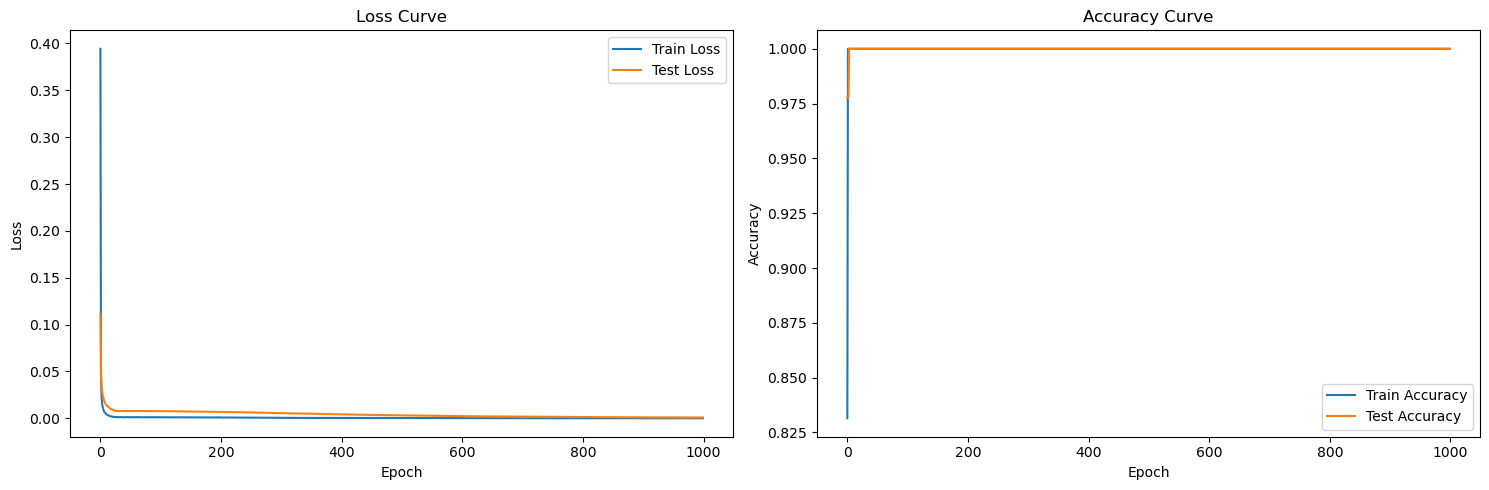

In [20]:
# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=1000
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [21]:
logreg_model= best_loss_model
logreg_model


LogisticRegression(
  (linear): Linear(in_features=512, out_features=2, bias=True)
)

# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=100
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [22]:
# Save the best models by accuracy and loss
torch.save(best_acc_model.state_dict(), "1000epoch_best_acc_model.pth")
torch.save(best_loss_model.state_dict(), "1000epoch_best_loss_model.pth")


In [28]:
logreg_model = LogisticRegression(512,2)
logreg_model = logreg_model.to(device)

In [55]:



# Step 2: Load the saved state dict
state_dict = torch.load("1000epoch_best_loss_model.pth")  # Load weights from the file
logreg_model.load_state_dict(state_dict)  # Load state dict into the model

# Step 3: Set the model to evaluation mode (if not training)
logreg_model.eval()  # This disables dropout and batchnorm for inference


C:\Users\k54739\AppData\Local\Temp\ipykernel_22448\4036842466.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("1000epoch_best_loss_model.pth")  #

LogisticRegression(
  (linear): Linear(in_features=512, out_features=2, bias=True)
)

# 512= feature_dim = train_feats_simclr.tensors[0].shape[1] =  before projection head

# Save model state_dict
torch.save(logreg_model.state_dict(), "logreg_model_best.pth")


In [56]:

# 1000 epochs: no outlier amoung exploded, control7, single dose
#500 epochs, one outlier of exploder in ds closer to sd: which is ds41_g9_C10-T01   inbetween 4 ds closer
# 100 epochs, one outlier of exploder also one outlier from ds_clos_tosd ds41_g5_E04-T01



# we got 100 % down checking whether we will get it by repeating

Extracting Features: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


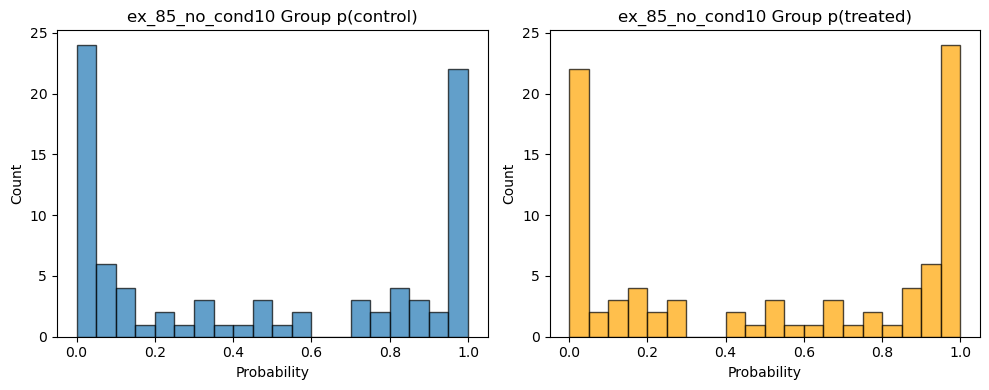

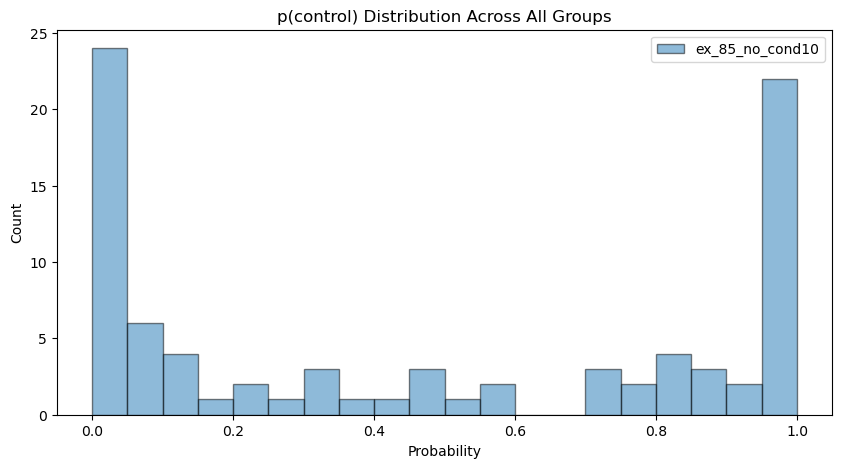

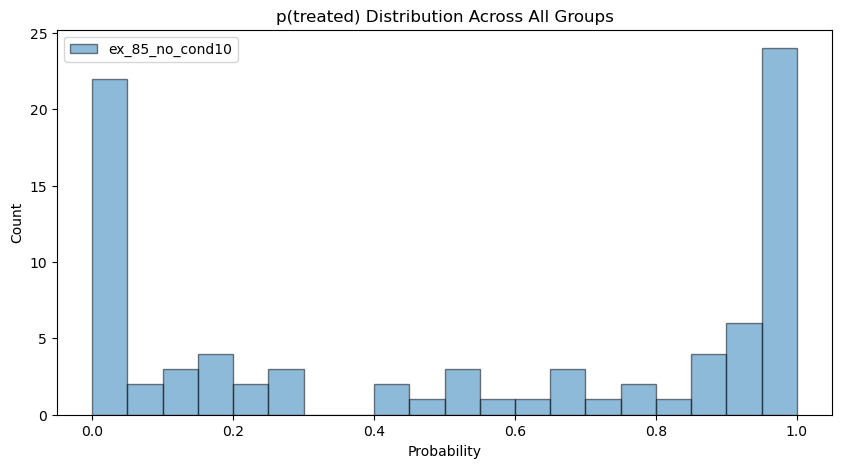

In [51]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [52]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending ordergroups_data[group_name]
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

Images sorted by p(treated) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85\ex_85_no_cond10\ds_61_B08-T01.tiff: 0.0003
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85\ex_85_no_cond10\ds_61_B11-T01.tiff: 0.0005
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85\ex_85_no_cond10\ds_61_B07-T01.tiff: 0.0007
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85\ex_85_no_cond10\ds_61_F06-T01.tiff: 0.0011
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85\ex_85_no_cond10\ds_1b_C8.tif: 0.0011
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85\ex_85_no_cond10\ds_1b_C7.tif: 0.0020
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85\ex_85_no_cond10\ds_41_C02-T01.tiff: 0.0032
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85\ex_85_no_cond10\ds_61_F03-T01.tiff: 0.0052
C:\Users\k54739\Bibi_new_thesis\thes

In [54]:
import os
import shutil

# Assuming 'sorted_by_treated' is already defined as:
# sorted_by_treated = [(img_path, p_tr), ...] sorted in ascending order by p_tr

new_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sort_ex_85"
os.makedirs(new_dir, exist_ok=True)

for i, (img_path, p_tr) in enumerate(sorted_by_treated, start=1):
    # Extract the parent directory name and the original filename
    parent_dir_name = os.path.basename(os.path.dirname(img_path))  # e.g. "cond7"
    base_filename = os.path.basename(img_path)  # e.g. "ds_41.tif"
    
    # Combine them to get "cond7_ds_41.tif"
    original_filename = f"{parent_dir_name}_{base_filename}"

    # Format the probability score
    formatted_score = f"{p_tr:.4f}"
    
    # Construct the new filename with index and score
    new_filename = f"{i}_{formatted_score}_{original_filename}"
    new_path = os.path.join(new_dir, new_filename)
    
    shutil.copy2(img_path, new_path)

print("Images copied and renamed successfully!")


Images copied and renamed successfully!


# 100 %

Extracting Features: 100%|██████████| 18/18 [00:12<00:00,  1.42it/s]


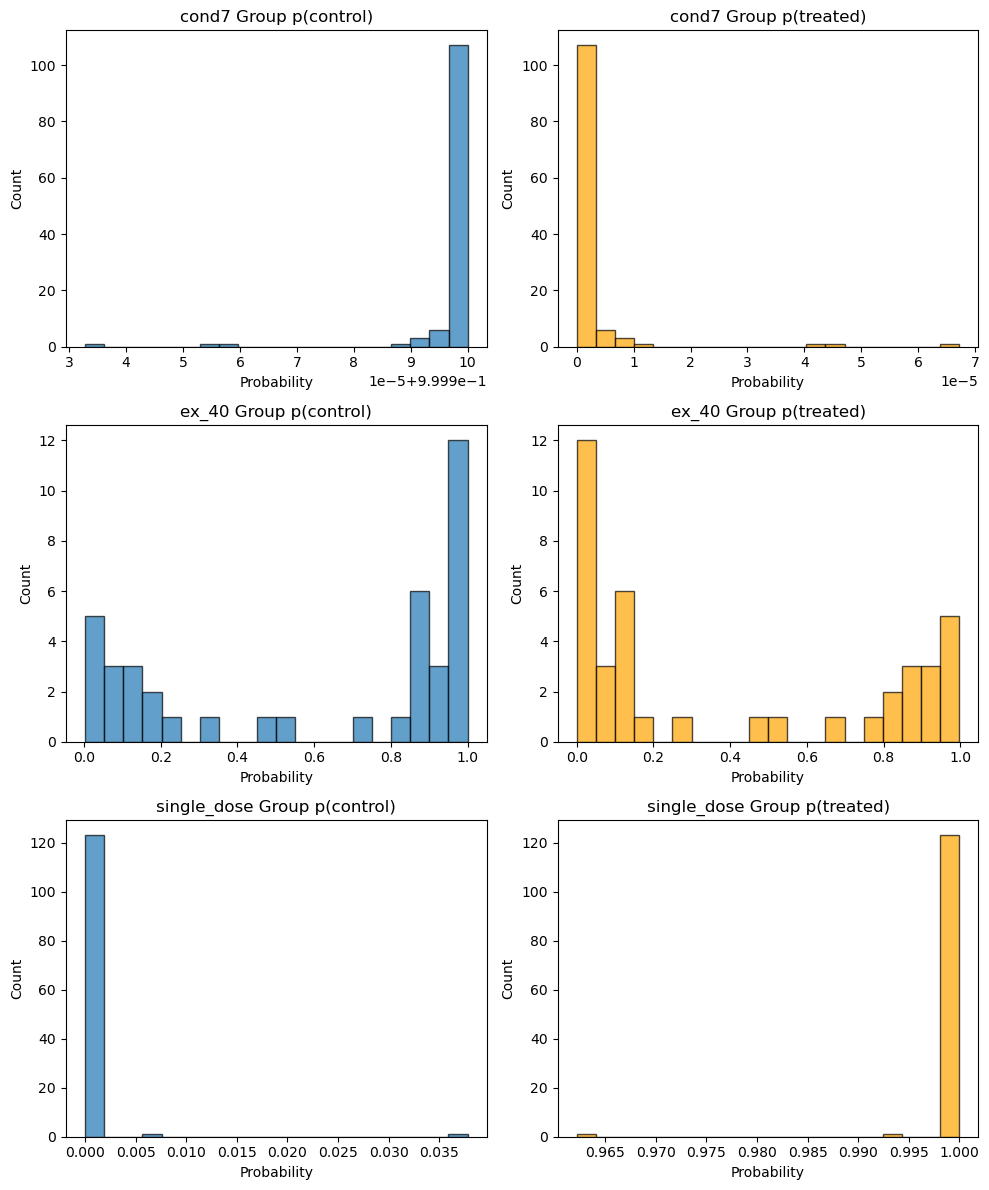

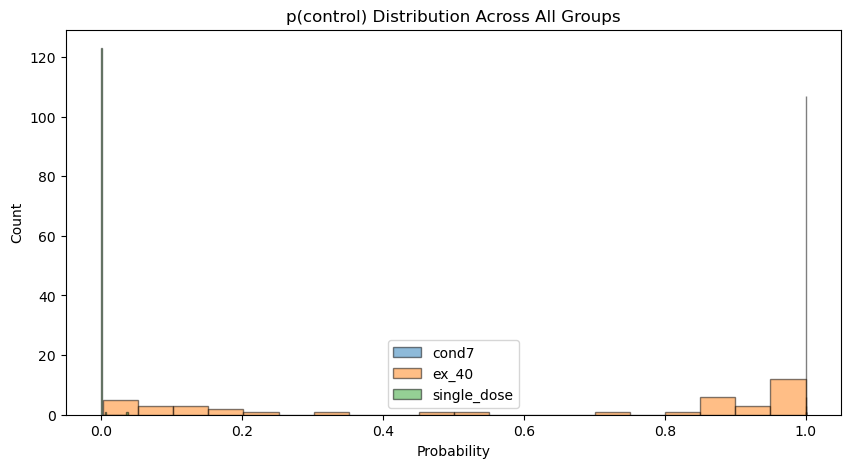

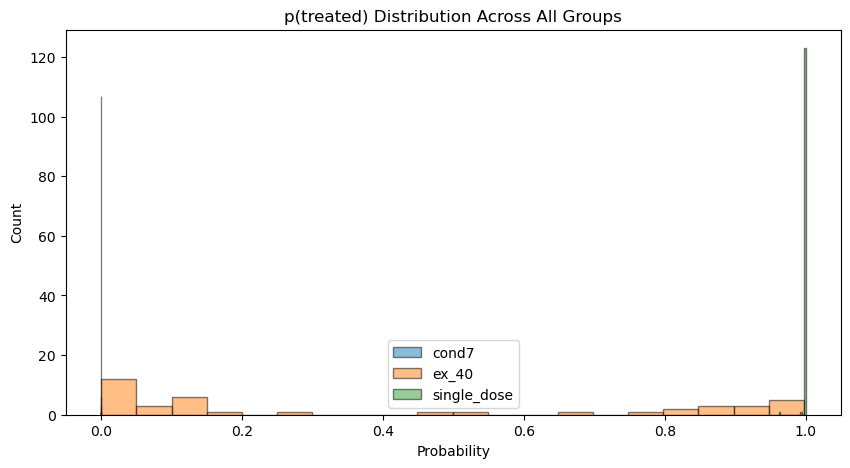

In [23]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [24]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending ordergroups_data[group_name]
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

Images sorted by p(treated) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_G03-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_F11-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBTDS1B_Day_7_G06-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_G02-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_B03-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_B10-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBTDS1B_Day_7_C08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_c

In [25]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1], entry[0]) for entry in all_images_data]

# Print sorted images
print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr, p_ctrl in sorted_by_treated:
    print(f"{img_path}: p(treated)={p_tr:.4f}, p(control)={p_ctrl:.4f}")

# Initialize group-wise data
grouped_data = {group: [] for group in groups}
for group in groups:
    grouped_data[group].extend(groups_data[group])

# Step 1: Sort distances and keep track of group membership
sorted_distances = []
for group, data in grouped_data.items():
    for _, p_treated, _ in data:
        sorted_distances.append((p_treated, group))

sorted_distances.sort(key=lambda x: x[0])  # Sort by p(treated)

# Step 2: Check for correct transitions between groups
correct_transitions = 0
total_transitions = len(groups) - 1  # Total possible adjacent group transitions

for i in range(total_transitions):
    group_i = groups[i]
    group_j = groups[i + 1]

    # Get all distances for groups i and j
    distances_i = [dist for dist, grp in sorted_distances if grp == group_i]
    distances_j = [dist for dist, grp in sorted_distances if grp == group_j]

    # Check the condition: all d in G_i < all d in G_j
    if all(d_i < d_j for d_i in distances_i for d_j in distances_j):
        correct_transitions += 1

# Step 3: Calculate ranking accuracy
ranking_accuracy = correct_transitions / total_transitions if total_transitions > 0 else 1.0

# Step 4: Print the group-wise ranking accuracy
print("\nGroup-Wise Ranking Accuracy:")
print(f"Correct Transitions: {correct_transitions}")
print(f"Total Possible Transitions: {total_transitions}")
print(f"Ranking Accuracy: {ranking_accuracy:.4f}")


Images sorted by p(treated) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_G03-T01.tiff: p(treated)=0.0000, p(control)=1.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_F11-T01.tiff: p(treated)=0.0000, p(control)=1.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBTDS1B_Day_7_G06-T01.tiff: p(treated)=0.0000, p(control)=1.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_G02-T01.tiff: p(treated)=0.0000, p(control)=1.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_B03-T01.tiff: p(treated)=0.0000, p(control)=1.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy\cond7\RBT_01.04_Day7_B10-T01.tiff: p(treated)=0.0000, p(control)=1.0000
C:\Us

In [ ]:
import os
import shutil

# Assuming 'sorted_by_treated' is already defined as:
# sorted_by_treated = [(img_path, p_tr), ...] sorted in ascending order by p_tr

new_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sorted_explodall"
os.makedirs(new_dir, exist_ok=True)

for i, (img_path, p_tr) in enumerate(sorted_by_treated, start=1):
    # Extract the parent directory name and the original filename
    parent_dir_name = os.path.basename(os.path.dirname(img_path))  # e.g. "cond7"
    base_filename = os.path.basename(img_path)  # e.g. "ds_41.tif"
    
    # Combine them to get "cond7_ds_41.tif"
    original_filename = f"{parent_dir_name}_{base_filename}"

    # Format the probability score
    formatted_score = f"{p_tr:.4f}"
    
    # Construct the new filename with index and score
    new_filename = f"{i}_{formatted_score}_{original_filename}"
    new_path = os.path.join(new_dir, new_filename)
    
    shutil.copy2(img_path, new_path)

print("Images copied and renamed successfully!")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import shutil

# Assuming 'sorted_by_treated' is already defined as:
# sorted_by_treated = [(img_path, p_tr), ...] sorted in ascending order by p_tr

new_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sorted_cond10"
os.makedirs(new_dir, exist_ok=True)

for i, (img_path, p_tr) in enumerate(sorted_by_treated, start=1):
    # Extract the parent directory name and the original filename
    parent_dir_name = os.path.basename(os.path.dirname(img_path))  # e.g. "cond7"
    base_filename = os.path.basename(img_path)  # e.g. "ds_41.tif"
    
    # Combine them to get "cond7_ds_41.tif"
    original_filename = f"{parent_dir_name}_{base_filename}"

    # Format the probability score
    formatted_score = f"{p_tr:.4f}"
    
    # Construct the new filename with index and score
    new_filename = f"{i}_{formatted_score}_{original_filename}"
    new_path = os.path.join(new_dir, new_filename)
    
    shutil.copy2(img_path, new_path)

print("Images copied and renamed successfully!")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [25]:
#500 epochs, one outlier of exploder in ds closer to sd: which is ds41_g9_C10-T01   inbetween 4 ds closer
# 100 epochs, one outlier of exploder also one outlier from ds_clos_tosd ds41_g5_E04-T01



In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

# Inference

In [6]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

In [7]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model structure
feature_dim = 512 # Set this to the same dimension used during training
num_classes = 2   # Since you trained for 2 classes
logreg_model = LogisticRegression(feature_dim, num_classes).to(device)

# Load the saved weights
logreg_model.load_state_dict(torch.load("best_loss_model.pth", map_location=device))
logreg_model.eval()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


# descending order

all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in descending order (highest p(treated) first)
all_images_data.sort(key=lambda x: x[1], reverse=True)

# Now all_images_data is sorted by p(treated)
# Extract (img_path, p_treated)
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

# Print or handle as needed
print("Images sorted by p(treated) in descending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [15]:
# ascending order

In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [15]:
from copy import deepcopy
import torchvision.transforms.functional as TF

In [16]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))
    
    return image


In [18]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff'

In [ ]:
first_image = Preprocess_Image(path_of_image)
print(first_image.shape)
prep_first_image = first_image.unsqueeze(0)
print(prep_first_image.shape)

In [ ]:
first_image_np = first_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(first_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('First Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [ ]:
pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff'
second_image = Preprocess_Image(pathimage)
print(second_image.shape)
prep_second_image = second_image.unsqueeze(0)
print(prep_second_image.shape)


In [ ]:
second_image.shape

In [ ]:
second_image_np = second_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(second_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('second Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [24]:
@torch.no_grad()
def extract_features(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [ ]:
print(f"simclr_model: {simclr_model}")

In [ ]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, prep_first_image)
second_image_feats = extract_features(simclr_model, prep_second_image)
print(first_image_feats.shape)
print(second_image_feats.shape)

In [ ]:
# COSINE FROM NEWDATA CROP VAL&INFER
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# COSINE old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
im_path = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff'
untreated_image = Preprocess_Image(im_path)
print(untreated_image.shape)
prep_untreated_image = untreated_image.unsqueeze(0)
print(prep_untreated_image.shape)

In [ ]:
untreated_image_np = untreated_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(untreated_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('untreated Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [30]:
untreated_image_feats = extract_features(simclr_model, prep_untreated_image)

In [ ]:
# COSINE NEW DATA CROP
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Inference after projection head

In [32]:
@torch.no_grad()
def features_after_projection(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [ ]:
# Extract features for both images
first_image_feats_after = features_after_projection(simclr_model, prep_first_image)
second_image_feats_after = features_after_projection(simclr_model, prep_second_image)
print(first_image_feats_after.shape)
print(second_image_feats_after.shape)

In [ ]:
# Cosine newdata crop 
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# Cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

#Cosine similarity between features: 0.8507535457611084


as expected after projection head cosine similarity is higher this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

In [ ]:
untreated_image_feats_after = features_after_projection(simclr_model, prep_untreated_image)
print(untreated_image_feats_after.shape)

In [ ]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

as expected after projection head cosine similarity is lower for different class images this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

Orig images (without simclr)

In [ ]:
print(first_image)
first_image.view(-1).shape


In [ ]:
print(second_image)
second_image.view(-1).shape

In [40]:
first_flat = first_image.view(-1)
second_flat = second_image.view(-1)

In [ ]:
first_flat.unsqueeze(0).shape == untreated_flat.unsqueeze(0)

In [ ]:
import torch.nn.functional as F
similarity = F.cosine_similarity(first_flat.unsqueeze(0), second_flat.unsqueeze(0))
similarity

In [44]:
untreated_flat = untreated_image.view(-1)

In [ ]:
similarity = F.cosine_similarity(first_flat.unsqueeze(0), untreated_flat.unsqueeze(0))
similarity

In [ ]:
first_flat == untreated_flat

orig without resizing

In [ ]:
import numpy as np
import tifffile as tiff
from numpy.linalg import norm

# Load and normalize both images
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")


In [ ]:
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")

In [ ]:
WAS IST DAS?
Mach kein Sinn!

In [74]:
img1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
img2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')
img3 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')
img1_flattened = img1.flatten()
img2_flattened = img2.flatten()
img3_flattened = img3.flatten()

In [ ]:
cosine_similarity = np.dot(img1_flattened, img2_flattened) / (norm(img1_flattened) * norm(img2_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

In [ ]:
cosine_similarity = np.dot(img1_flattened, img3_flattened) / (norm(img1_flattened) * norm(img3_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

In [ ]:
img1

In [ ]:
img2

In [ ]:
img3

so, if we didn't use simclr and just try to find the cosine similarity between orig images: it doesn't deviate too  much not good.